## Trigger Word Detection Assistant

Now there can be various different situations in which the trigger words can be spoken, in order to make the model better at detecting those words it is important to mimic the situations where there can be lot of background noise. For that we are going to overlap speech audio files with background noise audio files so as to create that effect.<br>
The main reason behind not using audio in actual noisy environment is because during labelling the Y labels for the timesteps we need to know where the **"activate"** word ends , now using synthesised data we will be knowing exactly where the word **"activate"** ends and makes labelling easier. 

In [72]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from utility import *
import subprocess
%matplotlib inline

Loading necessary Keras library modules

In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


## Dataset
The audio data used in this model has been sampled at 44100 Hz i.e, that many numbers are produced each second to represent the audio. But for the model we are going to use the **spectogram** of the audio and use 5511 timesteps. We will be using **10 seconds** for each clip for the model. That means we are going to divide the 10seconds time interval into 5511 intervals. Incase the audio file is shorter it will be padded or if longer it will be truncated.<br> **Tx = 5511**. <br>
We will use 1375 timesteps for output.<br>
**Ty = 1375**.<br>
A spectogram is a graphical representation between the timesteps and frequency.

In [3]:
# input timesteps
Tx = 5511
# output timesteps
Ty = 1375
# No. of frequencies input to the model at each timestep
n_freq = 101

## Data preparation
We will overlay the various speech audio clips on top of background audio files. For doing that it needs to be ensured that there is no overlap of audio clips with already overlayed audio clips on the background. Then we label the audio data , we make the Yi for the timestep when the positive audio clip ends "1" and also make the next 50 timesteps as "1" also, so that the model can detect the presence of "activate" in very short duration also.<br>
The basic strategy will be:
1. Generate a random time segment.
2. Check if the generated segment causes an overlap or not for the new audio clip. If overlap happens then again generate a new segment, if not then add the new audio clip on top of background and add this time segment to the list of overlayed time segments.
3. Label the output Y labels by adding 1s.

In [4]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """

    # Make sure segment doesn't run past the 10sec background
    segment_start = np.random.randint(low = 0, high = 10000 - segment_ms)
    segment_end = segment_start + segment_ms - 1

    return (segment_start, segment_end)

In [5]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """

    segment_start, segment_end = segment_time

    # initially there is no overlap is assumed
    overlap = False

    # loop over the previous segments already overlayed for finding any overlap with current segment
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_start >= previous_start:
            overlap = True

    return overlap

In [6]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, making sure that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """

    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)

    # Step 1: get a ranodm time segment
    segment_time = get_random_time_segment(segment_ms)

    # Step 2: Check for overlap with previous time segments
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments 
    previous_segments.append(segment_time)
   
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position=segment_time[0])

    return new_background, segment_time

In [7]:
 def insert_ones(y, segment_end_ms):
    """
    for updating the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. 
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """

    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)

    # last timestep for inserting 1
    end_index = y.shape[1] - 1
    # check if end_index goes out of output timesteps or not
    if segment_end_y + 51 < y.shape[1]:
        end_index = segment_end_y + 51
    # make the required steps as 1
    y[0, segment_end_y + 1:end_index] = 1
    
    return y


In [8]:
def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """

    # Set the random seed
    np.random.seed(18)

    # Make background quieter
    background = background - 20

    # Step 1: Initialize y (label vector) of zeros 
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list 
    previous_segments = list()
   
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(
        len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]

    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(
            background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)
   
    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(
        len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background
        background, _ = insert_audio_clip(
            background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip
    background = match_target_amplitude(background, -20.0)

    # Export new training example
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")

    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")

    return x, y

### Load the training and dev data
** Note:** We will be using pretrained model, incase the model needs again training then the following lines should be uncommented


In [9]:
'''# load the preprocessed training examples
X_train = np.load("./XY_train/X.npy")
Y_train = np.load("./XY_train/Y.npy")

# Load preprocessed dev set examples
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")'''

'# load the preprocessed training examples\nX_train = np.load("./XY_train/X.npy")\nY_train = np.load("./XY_train/Y.npy")\n\n# Load preprocessed dev set examples\nX_dev = np.load("./XY_dev/X_dev.npy")\nY_dev = np.load("./XY_dev/Y_dev.npy")'

## <u>Model Architecture

**Step 1**: We will use a 1D CONV layer for extracting low level features from the audio file. This also makes our output smaller in dimension.

We will be using two GRU layers.

**Step 2**: First GRU layer. Output from this layer is passed onto the next GRU layer, but before that it goes through batch Normalization and Dropout layers.

**Step 3**: Second GRU layer. 

**Step 4**: We create a time-distributed dense layer. Reason behind using TimeDistributed Layer is that we want the output from each timestep and pass it forward, otherwise we end up with only the final timestep output.
We have used sigmoid activation since the output can be 0 or 1 only.

In [4]:
def create_model(input_shape):
    """
    for creating Keras Model graph.
    
    Arguments:
    input_shape -- shape of the model's input data 

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # Step 1: CONV layer : for extracting features
    X = Conv1D(filters = 196, kernel_size = 15, strides=4)(X_input)         # CONV1D
    X = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(X)        # Batch normalization
    X = Activation('relu')(X)                                               # ReLu activation
    X = Dropout(0.8)(X)                                                     # dropout (use 0.8)

    # Step 2: First GRU Layer
    X = GRU(units = 128, return_sequences = True)(X)                     # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                                  # dropout (use 0.8)
    X = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(X)     # Batch normalization
    
    # Step 3: Second GRU Layer
    X = GRU(units = 128, return_sequences = True)(X)                 # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                              # dropout (use 0.8)
    X = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(X)  # Batch normalization
    X = Dropout(0.8)(X)                                               # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)        # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [5]:
model = create_model(input_shape = (Tx, n_freq))

### Model Overview

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1375, 128)         0         
__________

Loading a pretrained model using 4000 examples since Trigger word detection takes a long time to train. 

In [7]:
# load the model
model = load_model('./models/tr_model.h5')

##  <u>Model Dev Set Performance


In [70]:
from sklearn.metrics import f1_score

In [71]:
# evaluate the model performance
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")
loss, acc = model.evaluate(X_dev, Y_dev)

# reshapping 
Y_pred = model.predict(X_dev)
Y_pred = Y_pred.reshape(Y_pred.shape[0], -1)
Y_pred = Y_pred[:,:] >= 0.5
Y_dev = Y_dev.reshape(Y_dev.shape[0], -1)

f1 = f1_score(Y_dev, Y_pred, average='micro')  
print("Dev set accuracy = ", acc)
print("Dev set F1 score = ", f1)

25/25 [==============================] - 2s 71ms/step
Dev set accuracy =  0.950254559517
Dev set F1 score =  0.477703115455


## <u>Making Predictions

1. Compute the spectrogram for the given audio file.
2. Using `np.swap` and `np.expand_dims` for reshaping the input to size (1, Tx, n_freqs)
5. Using forward propagation find the model predictions for each time step.

In [44]:
def detect_triggerword(filename):
    '''
    For detecting the presence of trigger words in the audio file
    
    Arguments:
    filename -- name of input audio file 

    Returns:
    predictions -- output timestep predictions
    '''
    plt.subplot(2, 1, 1)
    # for generating the spectogram
    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('Probability')
    plt.show()
    return predictions

After finding the output predictions for each timestep of Ty, we need to insert the action that we want to perform when the word "activate" ends. For that we see in the output when 1 appears and then insert the action there and skip doing this for the next 75 timesteps since the next 75 timesteps are 1s only.

In [75]:
chime_file = "audio//half.wav"

def alert_on_activate(filename, predictions, threshold):
    '''
    For detecting the presence of trigger words in the audio file
    
    Arguments:
    filename -- name of input audio file 
    predictions -- output timestep predictions
    threshold --  for adjusting how precisly we want to detect the trigger word
    
    Returns:
        None
    '''
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
            
            # run the command that you want
            subprocess.call(r'C:\Program Files (x86)\Microsoft VS Code\Code.exe')
        
    audio_clip.export("output//detected_output.wav", format='wav')

## <u>User Interface


In [46]:
# for taking voice input from user
from voice_input import take_input

In [47]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    '''
    For detecting the presence of trigger words in the audio file
    
    Arguments:
    filename -- name of input audio file 

    Returns:
        None
    '''
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [48]:
# record the user audio and return the saved audio filename
# We record the audio till 10 seconds but rather for a shorter time and then pad, 
# since when the user wants the assistant to launch something then he/she should not wait for 10 seeconds.
file_name = "audio//"
file_name = file_name + take_input()

* Started Listening
* Done Listening


In [49]:
preprocess_audio(file_name)
IPython.display.Audio(file_name) # listen to the audio you uploaded 

C:\Users\SUSANTA\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7172: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


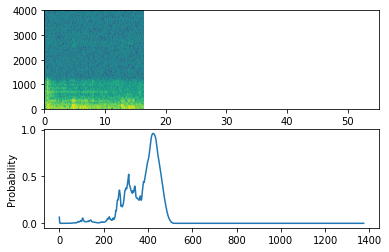

In [76]:
# for adjusting how precisly we want to detect the trigger word
alert_threshold = 0.5
prediction = detect_triggerword(file_name)
alert_on_activate(file_name, prediction, alert_threshold)
# incase if you want to know whether the trigger word was detected or not
IPython.display.Audio("output//detected_output.wav")

### Credits:

https://www.coursera.org/learn/nlp-sequence-models/home/welcome